# Convolutional Neural Network Classifier of Traffic Signs

In this project, we are given a data set of $51,839$ samples of $32\times32$ labeled RGB images of German traffic signs which can be found at this link, ([German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)). Our goal in this project is to build, train, and analyze an image classifier inspired by the LeNet Convolutional Neural Network (CNN) architecture.  We will perform data exploration, where we try to find some useful preprocessing steps that allows us to extract more useful features, artificially generate additional image samples through image transformations, build a CNN model in tensorflow, tune the model hyper-parameters, analyze the classifier operating characteristics, and finally examine the model filters that are generated from the training of the CNN.  

Many parts of this notebook are inspired by [Alex Staravoitau's work](https://navoshta.com/traffic-signs-classification/) His suggested architecture and regularization techniques are employeed in this notebook and I highly recommend viewing his work.  The work of [Pierre Sermanet and Yann LeCun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) is also key to finding features which work best for this task.

## Data Exploration and Augmentation

Lets take a look at the training data that is provided to us for this task

In [1]:
# import the required packages
import warnings
warnings.filterwarnings('ignore')

import pickle
import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# importing the pickled images data sets
training_file = 'data/train.p'
validation_file='data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# grab the class english labels
class_labels = pd.read_csv('signnames.csv')

### Basic Summary of the Data

In [3]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))

print("Total data set size = ", n_train+n_validation+n_test)
print("-"*20)
print("Number of training examples =", n_train)
print("Number of validation examples = ", n_validation)
print("Number of testing examples =", n_test)
print("-"*20)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Total data set size =  51839
--------------------
Number of training examples = 34799
Number of validation examples =  4410
Number of testing examples = 12630
--------------------
Image data shape = (32, 32, 3)
Number of classes = 43


Now lets visualize some of these examples by class of signage

In [6]:
# collecting images within the same classes
X_collections = []

for cls in range(n_classes):
    X_collections.append(X_train[y_train == cls])

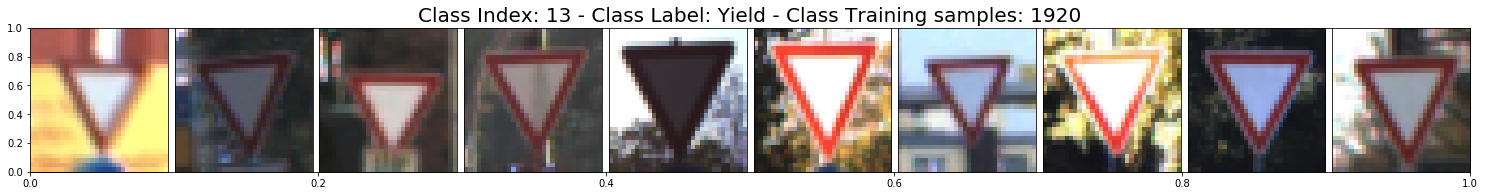

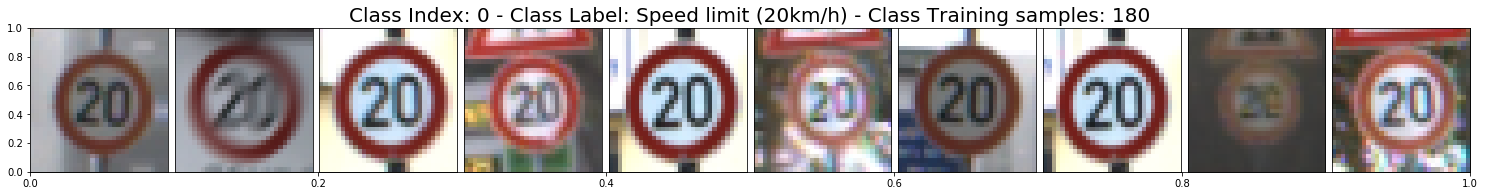

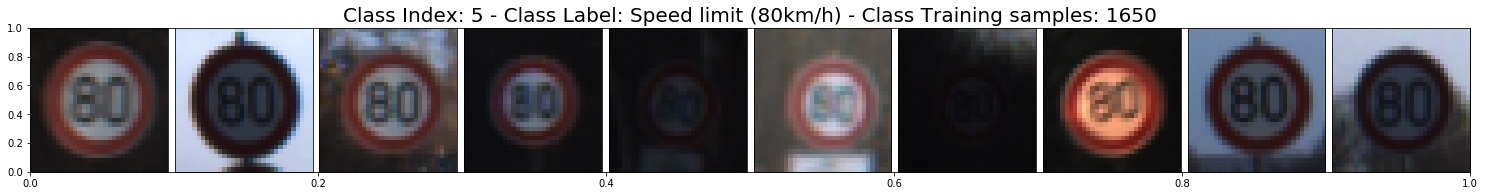

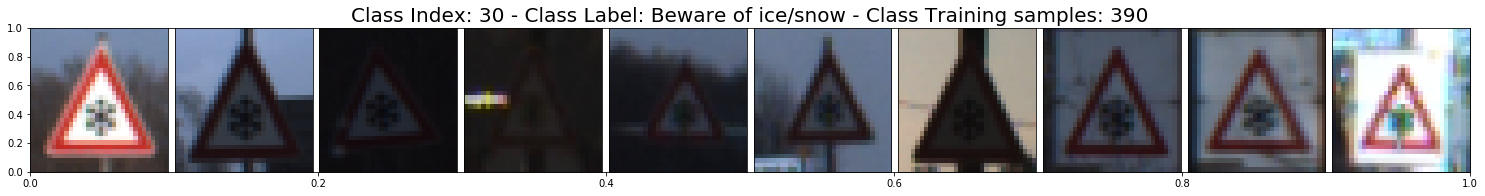

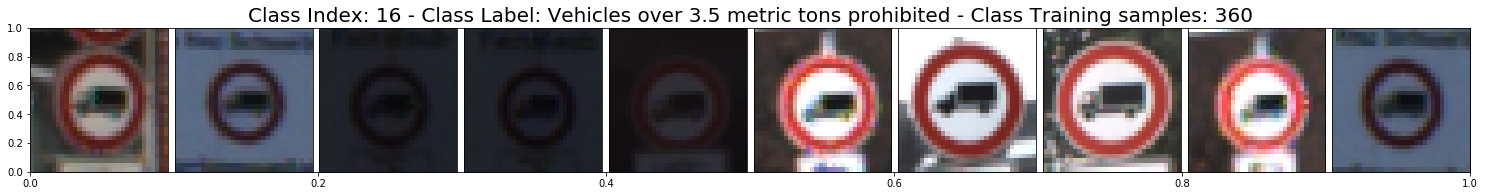

In [7]:
# Selecting 5 random classes to look at some samples
np.random.seed(1337)
rand_class_sample = np.random.choice(range(len(X_collections)),5,replace=False)

for cidx in rand_class_sample :
    clab = class_labels.values[cidx,1]
    title =("Class Index: %i - Class Label: %s - Class Training samples: %i" % (cidx,clab,len(X_collections[cidx])))
    fig = plt.figure(figsize = (20,2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    plt.title(title,fontsize=20)
    ridx = np.random.choice(range(len(X_collections[cidx])),10,replace=False)
    collection = X_collections[cidx][ridx]
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(collection[i],aspect="auto")
    plt.show()

Some significantly dark images appear in the data set but in general the images are mostly low res, highly zoomed in and centered signs that would be identifiable by a human. Let's take a look at the distribution of examples per class.

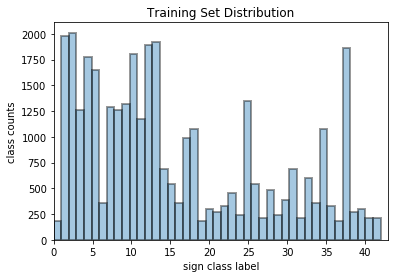

In [8]:
sns.distplot(y_train, bins=43,kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel("sign class label")
plt.ylabel("class counts")
plt.title("Training Set Distribution")
plt.xlim(0,43)
plt.show();

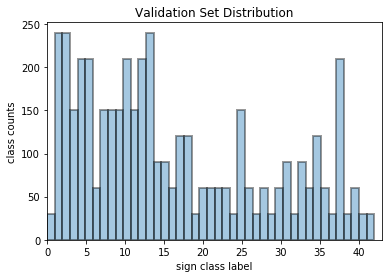

In [9]:
sns.distplot(y_valid,bins=43, kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel("sign class label")
plt.title("Validation Set Distribution")
plt.ylabel("class counts")
plt.xlim(0,43)
plt.show();

The training set and validation set seem to have pretty similar distributions by visual inspection. If we don't correct for uneven representation of signage in our training set we might find erroneously high accuracy on the validation set due to this similarity. The un-even number of examples per class posses a challenge because if the classifier used none of the information within the image, and randomly sampled from this histogram during it's classification step, it would give a base accuracy of:

$P(\hat{y}=y) = \sum_\hat{y} \sum_y P(y)P(\hat{y})I(\hat{y}=y) =  \sum_y P(y)^2 = \sum_y N_y^2/N^2 \approx 3.69\%$ 

versus when all classes have the same number of examples the base accuracy is 

$43 \frac{(N/43)^2}{N^2} = 1/43 \approx 2.32 \%$ so there is a slight bias in the dataset towards just guessing the more commonly occurring classes vs. actually learning and determining something from the image data which would be more applicable in the real world and any type of validation or test set.

We can correct for the bias by augmenting the dataset by artificially generating new examples that even out the samples in the data set.  Though this might introduce some bias towards artificial images that may never occur in nature. We will try our best to make our simulated images as real as possible, with the understanding that we may not be able to imagine what is the universe of all possible signs.

In order to simulate images of traffic signs we need to simulate various factors that effect an image e.g. angles of incidence, brightness levels, backgrounds, image noise, and sign orientation (rotation).  Applying rotations, perspective warps, noise addition, brightness changes, we can provide the model more examples of what we're trying to classify, making it more likely we'll have similar images in the testing, and validation sets, and ultimately the real world, to train against. Furthermore we can use this to even out the numbers of examples in each class such that we remove any inherent bias towards any one class so its more applicable to the real world. Below is the implementation of code for applying rotations, brightness changes, and random perspective changes, as well as using reflections to augment our dataset.  I neglect to include noise or blurring as Staravoitau's work showed this isn't particularly powerful modifications to the data.

In [4]:
# Augmenting the Dataset functions
def img_rotate(img,angle):
    tmp = np.copy(img)
    l,w,_ = tmp.shape

    M = cv2.getRotationMatrix2D((w/2,l/2),angle,1)
    dst = cv2.warpAffine(tmp,M,(w,l))
    
    # lots of geometery calcs were done to figure out how to
    # find the bounding box that doesn't have the black border
    # edges in a rotated image, this assumes l = w

    # conversion from degrees to radians
    a = angle*np.pi/180.
    
    # different bounds happen for positive angles vs negative ones
    if a > 0.0:
        denom = (np.cos(a)+np.sin(a))**2
        low = int(w*np.cos(a)*np.sin(a)/denom)
        hi = int(w*(1+np.cos(a)*np.sin(a))/denom)
    else:
        denom = 4*np.cos(a)*np.sin(a)-2
        low = int(w*np.sin(2*a)/denom)
        hi = int(w*(np.sin(2*a)-2)/denom)
        
    croped = dst[low:hi,low:hi]
    # reshaped
    dst = cv2.resize(croped,(l,w))
    return dst

def img_brightness_adjust(img,a=1.0,b=0.0):
    tmp = np.copy(img)
    for ch in range(3):
        tmp[:,:,ch] = np.clip(a*tmp[:,:,ch] + b, 0, 255)

    return tmp

# equalizes the image histograms in a local way
def img_3chEqualizer(img):
    tmp = np.copy(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
    for ch in range(3):
        tmp[:,:,ch] = clahe.apply(tmp[:,:,ch])
    return tmp

# perform random persepective warping and cropping
def img_rand_perspective(img,scale=0.0):
    nrows,ncols,_ = img.shape
 
    lx = 0
    ly = 0
    hx = nrows
    hy = ncols
    
    # source coords  #(UL,LL,LR,UR)
    src = np.float32([[lx,ly],[lx,hy],[hx,hy],[hx,ly]]) 
    
    # destination coordinates
    dyscale = nrows/2.*scale
    dxscale = ncols/2.*scale
    # upper left deviation
    ULdx = np.int32(np.random.uniform(low=-dxscale,high=dxscale))
    ULdy = np.int32(np.random.uniform(low=-dyscale,high=dyscale))
    
    # lower left deviation
    LLdx = np.int32(np.random.uniform(low=-dxscale,high=dxscale))
    LLdy = np.int32(hy+np.random.uniform(low=-dyscale,high=dyscale))
    
    # lower right deviation
    LRdx = np.int32(hx+np.random.uniform(low=-dxscale,high=dxscale))
    LRdy = np.int32(hy+np.random.uniform(low=-dyscale,high=dyscale))
    
    # upper right deviation
    URdx = np.int32(hx+np.random.uniform(low=-dxscale,high=dxscale))
    URdy = np.int32(np.random.uniform(low=-dyscale,high=dyscale))
    
    dst = np.float32([[ULdx,ULdy],
                      [LLdx,LLdy],
                      [LRdx,LRdy],
                      [URdx,URdy]])
    
    # finding x bounds
    lowx = np.argmin(np.array([ncols/2.-ULdx,ncols/2.-LLdx]))
    lowx = [ULdx,LLdx][lowx]
    if lowx < 0:
        lowx = 0
    hix = np.argmin(np.array([URdx-ncols/2.,LRdx-ncols/2.]))
    hix = [URdx,LRdx][hix]

    # finding y bounds
    lowy = np.argmin(np.array([nrows/2.-ULdy,nrows/2.-URdy]))
    lowy = [ULdy,URdy][lowy]
    if lowy < 0:
        lowy = 0
    hiy = np.argmin(np.array([LLdy-nrows/2.,LRdy-nrows/2.]))
    hiy = [LLdy,LRdy][hiy]
    
    # get the linear warp matrix
    M = cv2.getPerspectiveTransform(src,dst)
    # apply warp matrix
    warped = cv2.warpPerspective(img,M,(int(nrows*1.5),int(ncols*1.5)),flags=cv2.INTER_LINEAR)
    
    warped = warped[lowy:hiy,lowx:hix]
    warped = cv2.resize(warped,(ncols,nrows))
    
    return warped


# valid reflections taken from Staravoitau's work
# but the idea is some of the images are class label
# invariant to particular reflections, so we should 
# use to the reflections as part of our training data
def generate_all_reflections(X_data,y_data):
    
    # reflect along horizontal, still be classified as the same class label
    horizontal_classes = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    # reflect along vertical, still be classified as the same class label
    vertical_classes = [1, 5, 12, 15, 17]
    # reflect along 45 degree still classified as the same class label
    diagonal_classes = [32, 40]
    # mapping of classes when a vertical reflection is applied are mapped to a new label
    cross_flippable = {19:20,33:34,36:37,38:39,20:19,34:33,37:36,39:38}
    
    n_classes = len(np.unique(y_data))
    
    X_augment = np.empty([0, X_data.shape[1], X_data.shape[2], X_data.shape[3]], dtype = X_data.dtype)
    y_augment = np.empty([0], dtype = y_train.dtype)
    
    for c in range(n_classes):
        
        collection = X_data[y_data==c]
        
        if c in horizontal_classes:
            reflected = collection[:,:,::-1,:]
            labels = np.array(len(reflected)*[c])
            X_augment = np.append(X_augment,reflected,axis=0)
            y_augment = np.append(y_augment,labels,axis=0)
        
        if c in vertical_classes:
            reflected = collection[:,::-1,:,:]
            labels = np.array(len(reflected)*[c])
            X_augment = np.append(X_augment,reflected,axis=0)
            y_augment = np.append(y_augment,labels,axis=0)
        
        if c in diagonal_classes:
            reflected = collection[:,::-1,::-1,:]
            labels = np.array(len(reflected)*[c])
            X_augment = np.append(X_augment,reflected,axis=0)
            y_augment = np.append(y_augment,labels,axis=0)
        """    
        if c in cross_flippable.keys():
            reflected = collection[:,::-1,::-1,:]
            labels = np.array(len(reflected)*[cross_flippable[c]])
            X_augment = np.append(X_augment,reflected,axis=0)
            y_augment = np.append(y_augment,labels,axis=0)
        """
        
    X_augment = np.append(X_data,X_augment,axis=0)
    y_augment = np.append(y_data,y_augment,axis=0)
    
    return([X_augment,y_augment])

In [12]:
# generate and append all valid reflections to the training data
X_aug,y_aug = generate_all_reflections(X_train,y_train)

In [13]:
# original training size
X_train.shape

(34799, 32, 32, 3)

In [14]:
# training size after reflections included
X_aug.shape

(52289, 32, 32, 3)

### Reflections Added Training Distribution

Due to some of the images being class invariant to particular sets of reflections we automatically can expand our data set by applying reflections to each image that is label invariant to reflecitons.  Below we show the new distribution of classes after these reflections have been added to the training set.

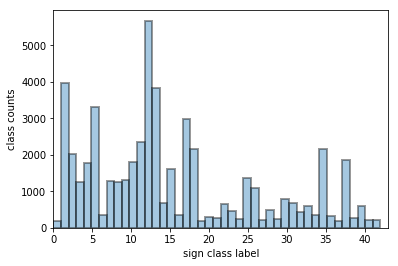

In [16]:
sns.distplot(y_aug, bins=n_classes, kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel("sign class label")
plt.ylabel("class counts")
plt.xlim(0,43)
plt.show();

## Simulating Data

Below is the implementation of various transformations of the data that simulate additional images in the training set, which include random rotations, and cropping such that no artifacts of the transformation is shown, though the angles of rotation are limited to be between -20 degrees and 20 degrees.  We also include local histogram normalization which adjusts brightness and contrast locally in each image in order try and correct the darkest images and create larger contrast on the features of the image. Random brightness/exposure additions are also included which are just simply scaling the image brightness up or down. I also apply random perspective warping taking care to crop the images such that no artifacts are included in the image and thus not learned by the model.  Examples of each transformation is done below.

### Rotations 

Rotations allow different views of the signage, but also introduces some artifacts that we don't want the classifier to be able to use as a feature.  So after some trigonometry I have cropped rotated images so that the artifacts are not present in the images.  Some tuning should be done such that you don't rotate too much as the filters might not be able to find important line angles that are relevant to identifying particular signs. An example of a rotation and crop is done below.

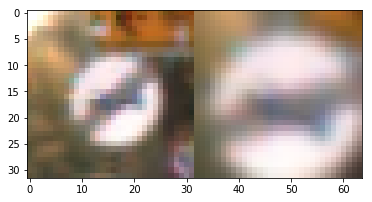

In [20]:
# showing the original and rotated by -25 degree image
plt.imshow(np.hstack((X_train[123],img_rotate(X_train[123],-25.))));

### Brightness

Different times of the day, or lighting conditions can effect the exposure of each image, so by varying the brightness of an image, we're simulating different lighting conditions/times of the day for the images. An example is done below.

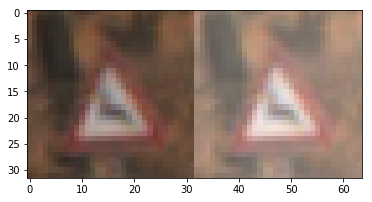

In [21]:
plt.imshow(np.hstack((X_train[300],img_brightness_adjust(X_train[300],a=1.0,b=60))));

### Equalization and Color spaces

Some of the images are quite dark, and even for a human its hard to figure out what the sign is.  We can adjust the contrast in each image so that we spread out the differences between the dark and light pixels in a method known as histogram equalization. This will significantly enhance the image contrast and allow those dark images to show more detail that makes it easier for a human to classify the images. An example is done below.

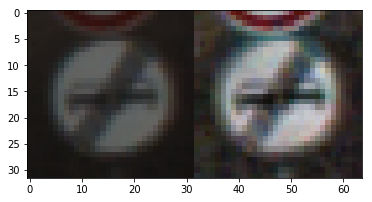

In [22]:
plt.imshow(np.hstack((X_train[20],img_3chEqualizer(X_train[20]))));

In addition to using histogram equalization to highlight useable features, we also want to experiment with just looking at different color spaces and using particular color space channels.  Specifically we look at the HLS color space and the L-channel as a viable candidate for a useful feature.  This is because on inspection the L-channels even in the dark images make seeing what the sign is very easy for a human and thus should translate to the machine learning procedure. Below we look at equalization and L-channel examples for a particularly dark original image.

In [19]:
# Selecting especially dark examples
dark_img_idxs = np.mean(np.mean(np.mean(X_collections[12],axis=3),axis=1),axis=1)<20
dark_examples = X_collections[12][dark_img_idxs]

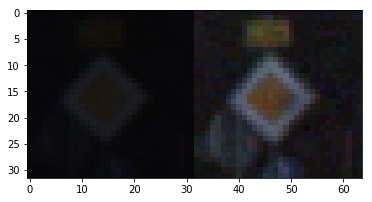

In [24]:
# showing the effect of the equalization on especially dark images
plt.imshow(np.hstack((dark_examples[0],img_3chEqualizer(dark_examples[0]))));

Now the same image when transferred to the HLS color space and the L-channel information, we can easily make out the sign in that case.

In [20]:
# switching to the HLS color space
hls = cv2.cvtColor(dark_examples[0],cv2.COLOR_RGB2HLS)

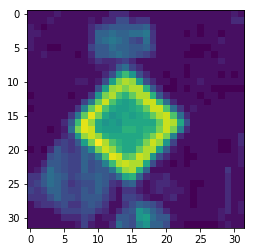

In [21]:
plt.imshow(hls[:,:,1]);

It's unclear which of these cases, using equalization + 3 color channels, using equalization + L-channel information, or using colors and no equalization or a single channel and no equalization.  We'll have to try them out and determine which works better. 

### Perspective Change

We also can add variety to our dataset by changing the perspective randomly in some of the images.  This allows our classifier to see more examples closer to real world examples that will likely be in the validation and test set, and therefore our classifier will generalize better. An example application is done below.

In [ ]:
np.random.seed(1337)

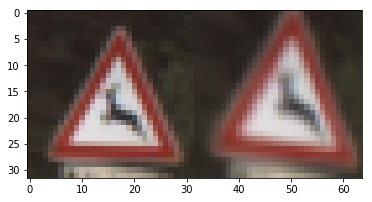

In [28]:
# note that the result of this function always is a random perspective change
# and you should not expect the same results for each run without setting
# the random seed, NOTE that you don't want to make scale much larger than 0.3
# as it will dramatically warp the image and make the region that viewable extremely
# small.  This will creating BAD examples to learn from an negatively impact your
# classifiers ability to learn 
plt.imshow(np.hstack((X_train[500],img_rand_perspective(X_train[500],scale=0.4))));

As an example of dramatic warping and also as a sanity check I display some perspective changed images from the augmented training dataset.

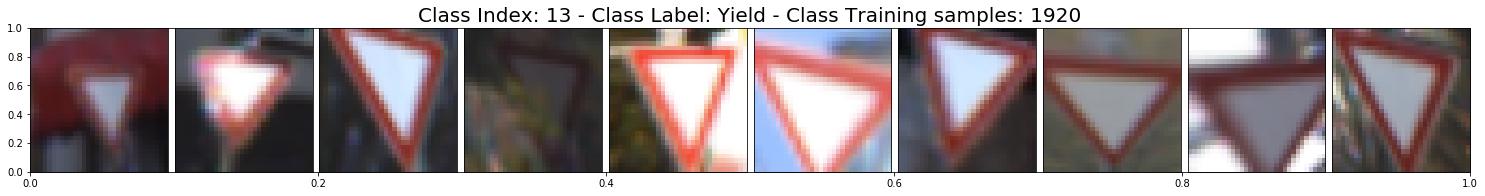

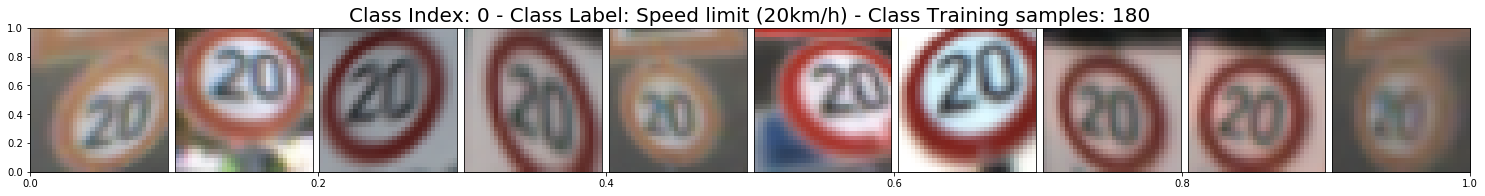

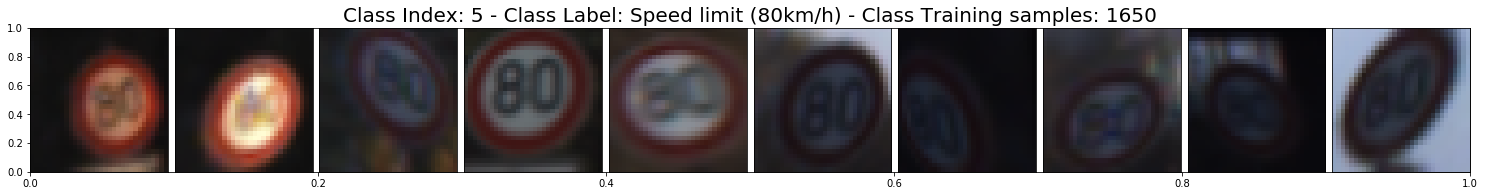

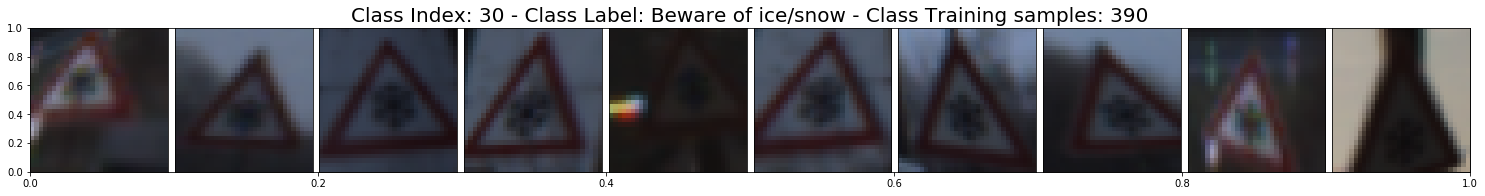

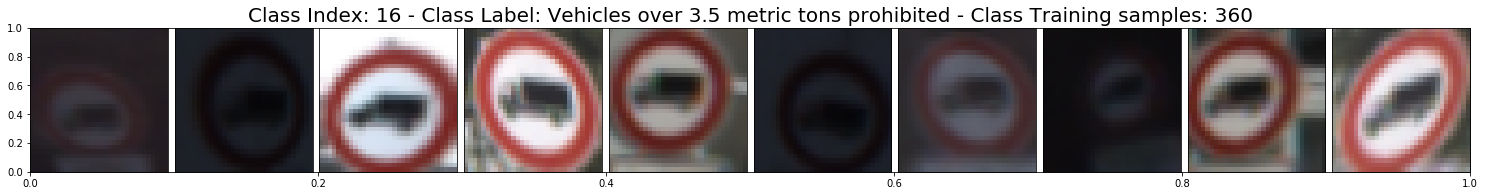

In [22]:
# Examples of dramatic warping in different classes
for cidx in rand_class_sample :
    clab = class_labels.values[cidx,1]
    title =("Class Index: %i - Class Label: %s - Class Training samples: %i" % (cidx,clab,len(X_collections[cidx])))
    fig = plt.figure(figsize = (20,2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    plt.title(title,fontsize=20)
    ridx = np.random.choice(range(len(X_collections[cidx])),10,replace=False)
    collection = X_collections[cidx][ridx]
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(img_rand_perspective(collection[i],scale=0.5),aspect="auto")
    plt.show()

### Generating Data

So with these operations, we want to generate some fake data but taking into account we want to generate more images for those with lower number of examples, so that we have the same number of examples for each class of sign.  We'll also want to experiment with if applying the histogram equalization or just taking the single L-channel of the HLS color space performs better or both. We'll also want to apply some sort of normalization technique, because the images are single or multiple channel pixel values between 0-255 we can rescale the pixel values to between 0 and 1 so that the CNN works more efficiently and avoids overflows/underflowing-exploding/vanishing gradients. We should try standardization as well but I do not do that in this notebook.  So how many images should we have per class? Well at a minimum we should have as many as the largest class, which we compute below.

In [23]:
n_samples_perclass = [len(X_collections[cidx]) for cidx in range(len(X_collections))]

In [24]:
# the class that has the most examples, has this many examples
max(n_samples_perclass)

2010

We're actually going to vastly increase the data set to about $430,000$ samples $(10,000)$ per class where some classes will contain many times more simulated data vs. sampled data, we hope this doesn't introduce too much bias towards simulated images and will generalize better toward more confidence in classifications in the end. 

Applying all of these transformations randomly is done in the function below, which also allows some of the preprocessing and normalization to take place without any simulated data being added, so that we can preprocess the validation and test data as well.  Furthermore we want to shuffle the training data set because we're going to be using stochastic gradient decent which requires that each batch be somewhat similar to the global data distribution so the gradient steps don't cause the weights to drift too far from their global optima in any one batch.

In [5]:
def augment_shuffle_norm(Xin_data, yin_data, nsamples_class=None, equalize=True, reshape_norm=False):
    # get some dimensions
    _,nrows,ncols,nchs = Xin_data.shape
    
    X_data = np.copy(Xin_data)
    y_data = np.copy(yin_data)
    
    if nsamples_class != None: # generate new data from the data with class equalization
        n_classes = len(np.unique(y_data))
        # initialize container for augmented data
        X_augmented = [[] for _ in range(n_classes)]
        #setting up the training target labels
        y_train = [[] for _ in range(n_classes)]
    
        for cls in range(n_classes): # for each class
            X_class = X_data[y_data == cls]
    
            ngenerate = nsamples_class-len(X_class)
            # if the class has more than nsamples_class just mix them up and give that back as the samples
            # for that class
            if ngenerate <= 0:
                # shuffle
                rand_idx = np.random.choice(range(len(X_class)),nsamples_class,replace=False)
                X_augmented[cls] = X_class[rand_idx]
                for nidx in range(len(X_augmented[cls])): # for each image apply
                    if equalize==True: # turn this on or off if you want to include hist eql in the RGB space
                        X_augmented[cls][nidx] = img_3chEqualizer(X_augmented[cls][nidx])
                    X_augmented[cls][nidx] = cv2.cvtColor(X_augmented[cls][nidx],cv2.COLOR_RGB2HLS)
            else:
                # if there aren't enough samples generate some modifed images where
                # the modifications are done randomly
                # shuffle
                rand_idx = np.random.choice(range(len(X_class)),ngenerate,replace=True)
                augset = X_class[rand_idx]
                for nidx in range(len(augset)): # for each image apply
                    # apply random rotation
                    rangle = np.random.uniform(low=-20.0,high=20)
                    augset[nidx] = img_rotate(augset[nidx],rangle)
                    # apply random brightening/darkening
                    rmag = np.random.uniform(low=-20,high=20)
                    augset[nidx] = img_brightness_adjust(augset[nidx],a=1.0,b=rmag)
                    
                    # apply random minor persepective change
                    augset[nidx] = img_rand_perspective(augset[nidx],scale=0.27)
                    
                    if equalize==True:
                        augset[nidx] = img_3chEqualizer(augset[nidx])
                    augset[nidx] = cv2.cvtColor(augset[nidx],cv2.COLOR_RGB2HLS)
        
                # join old set and augmented set
                X_augmented[cls] = np.vstack((X_class,augset))
            
            # generate the labels
            y_train[cls] = nsamples_class*[cls]
    
    else: # don't generate any new data just apply the transformations
        print("NO data generation")
        for nidx in range(len(X_data)): # for each image apply
            if equalize==True:
                X_data[nidx] = img_3chEqualizer(X_data[nidx])
            X_data[nidx] = cv2.cvtColor(X_data[nidx],cv2.COLOR_RGB2HLS)
        
        # normalize if selected
        if reshape_norm==True:
            print("Normalizing and shuffling")
            X_data = np.array(X_data)/255.
            X_data = X_data.reshape(-1,nrows,ncols,nchs)
            y_train = y_data.reshape(-1)
            
            # final shuffle
            len_Xdat = len(X_data)
            ridx = np.random.choice(range(len_Xdat),len_Xdat,replace=False)
            X_data = X_data[ridx]
            y_train = y_train[ridx]
        
        return([X_data,y_train])
    
    # ok if you make it here then all the data has been augmented and collected
    # now to reshape it and normalize it
    y_train = np.array(y_train)
    
    if reshape_norm==True:
        X_augmented = np.array(X_augmented)
        X_augmented = X_augmented.reshape(-1,nrows,ncols,nchs)
        X_augmented = X_augmented/255.
        y_train = y_train.reshape(-1)
        
        # final shuffle
        len_Xaug = len(X_augmented)
        ridx = np.random.choice(range(len_Xaug),len_Xaug,replace=False)
        X_augmented = X_augmented[ridx]
        y_train = y_train[ridx]
    
    return([X_augmented,y_train])        

Lets look some random samples of the augmented dataset below to make sure they look right, by looking at the L-channel in some sample images.

In [26]:
X_train_aug,y_train_aug = augment_shuffle_norm(X_aug, y_aug, nsamples_class=50, equalize=True, reshape_norm=False)

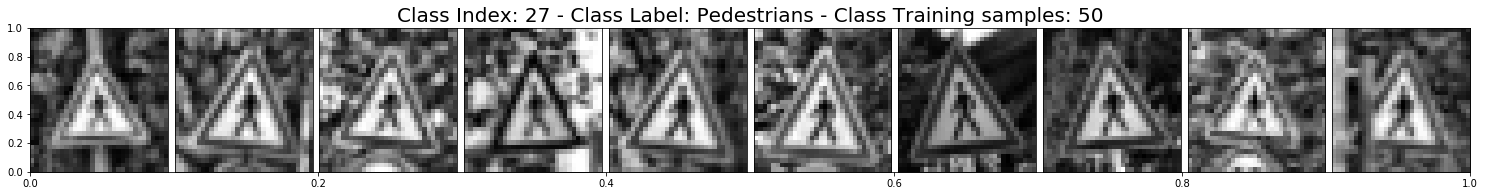

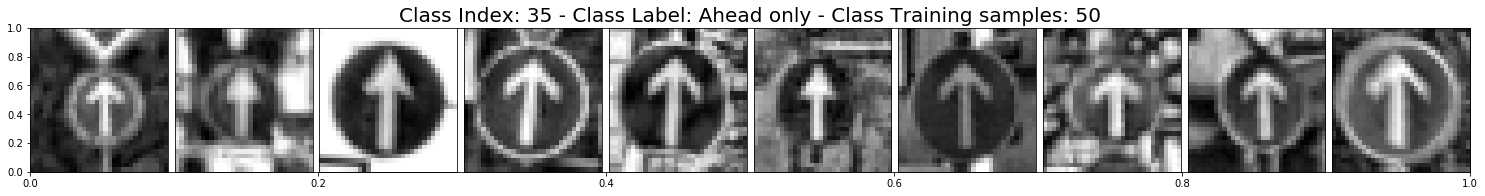

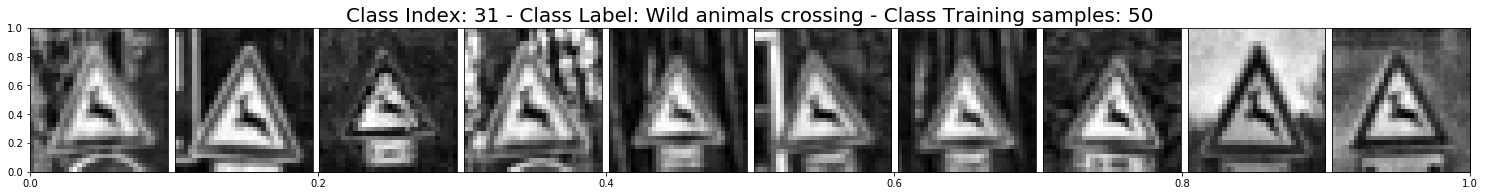

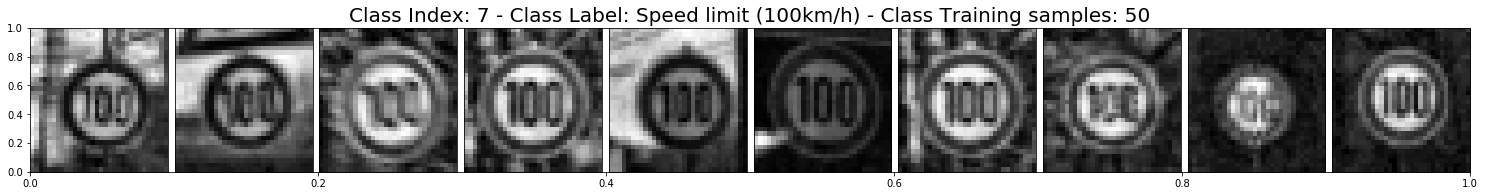

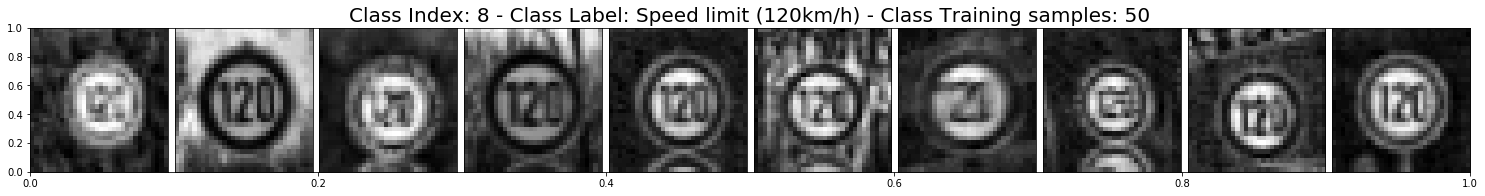

In [27]:
rand_class_sample = np.random.choice(range(len(X_train_aug)),5,replace=False)# selecting some random classes to show
nsamples_row = 10 # number of samples in each class to display

for cidx in rand_class_sample:
    cls = y_train_aug[cidx][0]
    clab = class_labels.values[cls,1]
    title=("Class Index: %i - Class Label: %s - Class Training samples: %i" % (cidx,clab,len(X_train_aug[cidx])))
    fig = plt.figure(figsize = (20,2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    plt.title(title,fontsize=20)
    
    ridx = np.random.choice(range(len(X_train_aug[cidx])),nsamples_row,replace=False)
    collection = X_train_aug[cidx][ridx]
    for i in range(nsamples_row):
        axis = fig.add_subplot(1, nsamples_row, i + 1, xticks=[], yticks=[])
        axis.imshow(collection[i][:,:,1],aspect="auto",cmap='gray')
    plt.show()

Okay they look good so lets make a much bigger data set to train with and apply the same preprocessing steps to the validation set, making sure not to generate any new examples on the validation set, and applying normalization and reshaping when needed like in the L-channel case.

In [8]:
np.random.seed(1337) # make sure we get the same training data everytime we run this
# note this can take a while
X_train_aug,y_train_aug = augment_shuffle_norm(X_aug, y_aug,nsamples_class=10000,equalize=True,reshape_norm=True)

In [9]:
#augmented trainning data in GB
print("Training data set is (GB): ", np.round((X_train_aug.nbytes)/(1024.)**3,2))

Training data set is (GB):  9.84


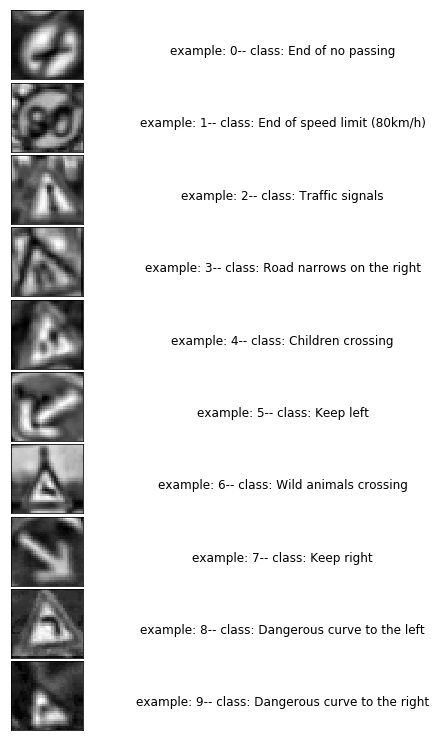

In [10]:
# Just make sure the training set looks correctly labeled, and shuffled
nsamples_col = 10
fig = plt.figure(figsize = (1,nsamples_col))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
ridx = [n for n in range(nsamples_col)]

for i in range(nsamples_col):
    cls = y_train_aug[ridx[i]]
    clab = class_labels.values[cls,1]
    axis = fig.add_subplot(nsamples_col, 1, i + 1, xticks=[], yticks=[])
    axis.imshow(X_train_aug[ridx[i]][:,:,1],aspect="auto",cmap='gray')
    axis.yaxis.set_label_position("right")
    axis.set_ylabel('example: '+str(i)+'-- class: '+clab,rotation=0, fontsize=12, labelpad=200)
plt.show()

In [11]:
# How many training examples do I have now?
X_train_aug.shape

(430000, 32, 32, 3)

In [30]:
# Verify the labels are the correct shape
y_train_aug.shape

(430000,)

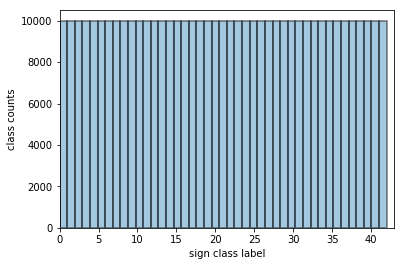

In [9]:
# Distribution by classes in the training set
sns.distplot(y_train_aug, bins=n_classes, kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel("sign class label")
plt.ylabel("class counts")
plt.xlim(0,43)
plt.show();

In [6]:
# applying the preprocessing to the validation set with no
# data generation or modifications done to it
X_valid_aug,y_valid_aug = augment_shuffle_norm(X_valid, y_valid, nsamples_class=None,equalize=True,reshape_norm=True)

NO data generation
Normalizing and shuffling


In [21]:
X_valid_aug.shape

(4410, 32, 32, 3)

In [22]:
y_valid_aug.shape

(4410,)

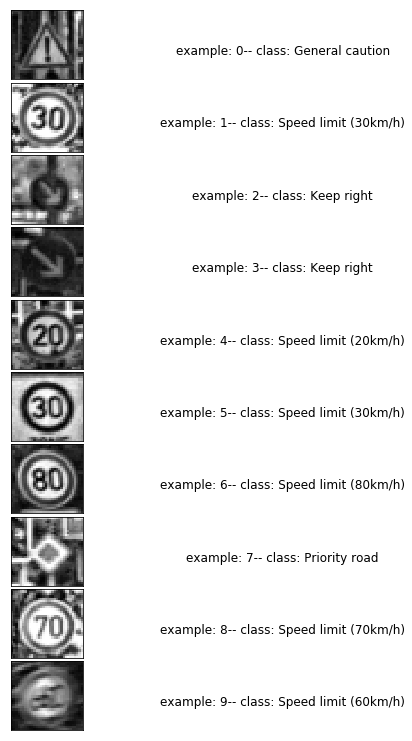

In [13]:
# make sure the validation set looks correctly labeled
nsamples_col = 10
fig = plt.figure(figsize = (1,nsamples_col))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
#ridx = np.random.choice(range(len(X_valid_aug)),nsamples_row,replace=False)
ridx = [n for n in range(nsamples_col)]
for i in range(nsamples_col):
    cls = y_valid_aug[ridx[i]]
    clab = class_labels.values[cls,1]
    axis = fig.add_subplot(nsamples_col,1, i + 1, xticks=[], yticks=[])
    axis.imshow(X_valid_aug[ridx[i]][:,:,1],aspect="auto",cmap='gray')
    axis.yaxis.set_label_position("right")
    axis.set_ylabel('example: '+str(i)+'-- class: '+clab,rotation=0, fontsize=12, labelpad=200)
    
plt.show()

In [ ]:
# creating the 1 channel versions where we
# select the L-channel from the HLS representation
X_train_aug_1ch = X_train_aug[:,:,:,1]
X_train_aug_1ch = X_train_aug_1ch.reshape(-1,32,32,1)

In [7]:
X_valid_aug_1ch = X_valid_aug[:,:,:,1]
X_valid_aug_1ch = X_valid_aug_1ch.reshape(-1,32,32,1)

In [31]:
# if you wanted to pickle this data set (but its quite big)
#aug_file = open('./train_aug_data.p', 'wb') 
#pickle.dump([X_train_aug,y_train_aug], aug_file)                      
#aug_file.close()

## Constructing a Convolutional Neural Network Classifier in Tensorflow

The model we're going to build is going to based on the LeNet-5 architecture with some modifications. We will have 2-3 convolutional layers of filter size (5x5) with "VALID" padding because the signs do not appear to be located near the edges of the images, so we shouldn't need to worry about any padding as implemented in tensorflow. We'll have to tune the number of filters at each level but generally we'll expand to more and more filters as we get deeper into the network.  After 2-3 convolution layers we attach the output to a single fully connected layer where the final output will be the logit values for each class.

We will have to experiment adding dropout and L2 regularization to the layers to help the network generalize to the validation and test sets.  We'll want to focus regularization penalties on the fully connected layer vs. the convolutional layer as the shared weights of the convolutional layer tends to be a regularizer on its own.

One really interesting modification to the LeNet architecture as suggested in Alex Staravoitau's work is the implementation of multi-feature scale classifier information by connecting the output of the shallow convolutional networks (with some max pooling) to both the following convolutional layer and also the fully connected layer.  This allows the fully connected layer to work on both complex features built up from lower level features but also combinations of lower level features (lines, edges, etc) and complex features together to make a robust classifier that considers multi scale features of the image.  A visualization of this architecture is taken from Staravoitau's work shown below.

![Staravoitau's architecture](./traffic-signs-architecture_diagram.png)

Staravoitau's image [source](https://navoshta.com/traffic-signs-classification/)

### Model Architecture

In [8]:
tf.reset_default_graph()

def CNN_MultiScaleFeatures(x, nclasses, fc_keep_prob=0.65, cov_keep_prob=0.9, nchannels=3):    
    # Arguments used for tf.truncated_normal, 
    # randomly defines variables for the weights 
    # and biases for each layer
    mu = 0.0
    sigma = 0.1
    
    # Layer 0: Convolutional with n_layer0, 1x1 filters
    # Input = 32x32x(nchannels). Output = 32x32x(n_layer0)
    n_layer0 = 32
    w0 = tf.Variable(tf.truncated_normal(shape=(5,5,nchannels,n_layer0),mean=mu,stddev=sigma),name='w0')
    b0 = tf.Variable(tf.zeros(n_layer0),name='b0')
    
    conv0 = tf.nn.conv2d(x,w0,strides=[1,1,1,1],padding='VALID',name='conv0')+b0
    conv0 = tf.nn.relu(conv0,name='conv0_relu')
    
    # Pooling Layer. max or avg we will try both
    # Input = 32x32x(n_layer0). Output = 16x16x(n_layer0).
    pool0 = tf.nn.max_pool(conv0,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID',name='pool0')
    pool0 = tf.nn.dropout(pool0,cov_keep_prob,name='dropout_0')
        
    # Layer 1: Convolutional with n_layer1, 5x5 filters
    # Input = 16x16x(nchannels). Output = 8x8x(n_layer1).
    n_layer1 = 64
    w1 = tf.Variable(tf.truncated_normal(shape=(5,5,n_layer0,n_layer1),mean=mu,stddev=sigma),name='w1')
    b1 = tf.Variable(tf.zeros(n_layer1),name='b1')
    
    conv1 = tf.nn.conv2d(pool0,w1,strides=[1,1,1,1],padding='VALID',name='conv1')+b1
    conv1 = tf.nn.relu(conv1,name='conv1_relu')

    # Pooling Layer. max or avg we will try both
    # Input = 28x28x(n_layer1). Output = 14x14x(n_layer1).
    pool1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,1,1,1],padding='VALID',name='pool1')
    pool1 = tf.nn.dropout(pool1,cov_keep_prob,name='dropout_1')

    # Layer 2: Convolutional with n_layer2, 5x5 filters,
    # Input = 14x14x(n_layer1). Output = 10x10x(n_layer2).
    n_layer2 = 128
    w2 = tf.Variable(tf.truncated_normal(shape=(5,5,n_layer1,n_layer2),mean=mu,stddev=sigma),name='w2')
    b2 = tf.Variable(tf.zeros(n_layer2),name='b2')
    
    conv2 = tf.nn.conv2d(pool1,w2,strides=[1,1,1,1],padding='VALID',name='conv2')+b2
    conv2 = tf.nn.relu(conv2,name='conv2_relu')

    # Pooling Layer. 
    # Input = 10x10x(n_layer2). Output = 5x5x(n_layer2).
    pool2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,1,1,1],padding='VALID',name='pool2')
    pool2 = tf.nn.dropout(pool2,cov_keep_prob,name='dropout_2')
    
    
    # Flatten conv layer0 and corse graining.
    # Input = 14x14x(n_layer1). Output = 14x14xn_layer1
    p0 = tf.nn.max_pool(pool0,ksize=[1,4,4,1],strides=[1,1,1,1],padding='VALID',name='p0')
    shape = p0.get_shape().as_list()
    fc_pool0 = tf.reshape(p0, [-1, shape[1] * shape[2] * shape[3]])
    flat0_size = shape[1] * shape[2] * shape[3]

    # Flatten conv layer1. 
    # Input = 5x5x(n_layer2). Output = 5x5xn_layer2.
    p1 = tf.nn.max_pool(pool1,ksize=[1,2,2,1],strides=[1,1,1,1],padding='VALID',name='p1')
    shape = p1.get_shape().as_list()
    fc_pool1 = tf.reshape(p1, [-1, shape[1] * shape[2] * shape[3]])  
    flat1_size = shape[1] * shape[2] * shape[3]
    
    # Flatten conv layer 2
    shape = pool2.get_shape().as_list()
    fc_pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])
    flat2_size = shape[1] * shape[2] * shape[3]
    
    # comment out these two lines if you dont want to use the
    # mutli-scale features
    flat = tf.concat([fc_pool0, fc_pool1, fc_pool2],1)
    fc_input_size = flat0_size+flat1_size+flat2_size
    
    # if you dont want to use the multi-scale features use these
    # 3 lines
    #shape = pool2.get_shape().as_list()
    #flat = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])
    #fc_input_size = shape[1] * shape[2] * shape[3]
    
    # Layer 3: Fully Connected. 
    # Input = flat1_size + flat2_size. Output = fc1_size.
    #fc1_size = int(2*(flat1_size+flat2_size))
    fc1_size = 1024
    w3 = tf.Variable(tf.truncated_normal(shape=(fc_input_size,fc1_size),mean=mu,stddev=sigma),name='w3')
    b3 = tf.Variable(tf.zeros(fc1_size),name='b3')
    
    fc = tf.matmul(flat,w3)+b3
    fc = tf.nn.relu(fc,name='fc_relu')
    fc = tf.nn.dropout(fc,fc_keep_prob,name='dropout_fc') # applying dropout to the FC layers
    
    # Layer 4: Fully Connected. Input = fc_size2. Output = nclasses.
    w4 = tf.Variable(tf.truncated_normal(shape=(fc1_size,nclasses),mean=mu,stddev=sigma),name='w4')
    b4 = tf.Variable(tf.zeros(nclasses),name='b4')

    logits = tf.matmul(fc,w4)+b4

    # i return the logits and some of the variables so that i have
    # handles to them outside of the function for analysis of 
    # the network later, and for use in L2 regularization
    return logits,w3,w4,conv0,conv1,conv2

In [9]:
n_ch = 1 # color channels of the data you want to input into the network select 1 or 3

# placeholder for the input shape of a batch of data
x = tf.placeholder(tf.float32, (None, 32, 32, n_ch),name='input')
# placeholder for the true class label
y = tf.placeholder(tf.int32, (None),name='labels')

# function to map labels to one hot vectors
one_hot_y = tf.one_hot(y, n_classes,name='ohe')

# placeholder2 to specify the keep probablity
# for the dropout layers
fc_keep_prob = tf.placeholder(tf.float32,name='fc_keep_prob')
cov_keep_prob = tf.placeholder(tf.float32,name='cov_keep_prob')

In [10]:
# initial learning rate for ADAM optimizer
lr = 0.0001 #0.001 for pre-training 0.0001 for fine-tuning
l2_lambda = 0.0001 # L2 regularization parameter

# constructing the CNN on the tf graph and getting the variable handles
logits,weight_3,weight_4,conv_0,conv_1,conv_2 = CNN_MultiScaleFeatures(x, n_classes, fc_keep_prob, cov_keep_prob, n_ch)
# x-entropy loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits,name='xentropy')

# L2 regularizer because this architecture overfits very easily
L2_0 = tf.nn.l2_loss(weight_3)
L2_1 = tf.nn.l2_loss(weight_4)
loss = tf.reduce_mean(cross_entropy,name='loss') + l2_lambda*(L2_0+L2_1)

# constructing the optimzation function
optimizer = tf.train.AdamOptimizer(learning_rate = lr,name='optimizer')
training_operation = optimizer.minimize(loss,name='training')

In [11]:
# functions for evaluation of how accurate our classifer is
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

# function that computes the mean accuracy over all the batches and gives
# the mean and standard deviation of the accuracy where the drop out is completed
# deactivated
def mean_batch_accuracy(X_data, y_data):
    num_examples = len(X_data)
    n_batches = 0
    batch_accuracy = 0.
    batch_var = 0.
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, fc_keep_prob: 1.0,  cov_keep_prob: 1.0})
        batch_accuracy += accuracy
        batch_var += accuracy**2
        n_batches += 1

    mean = batch_accuracy/n_batches
    std = np.sqrt(batch_var/(n_batches-1) - mean**2)
    return [mean,std]

# computes the accuracy over the entire data set provided
def mean_accuracy(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0.0
    n_batches=0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        acc = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, fc_keep_prob: 1.0,  cov_keep_prob: 1.0})
        total_accuracy += (acc*len(batch_x))
        n_batches+=1
        

    mean = total_accuracy/float(n_batches*BATCH_SIZE)
    std = 0.0
    return [mean,std]

### Executing Model Training

Here we're running batches through the training algorithm with an ADAM optimizer performing stochastic gradient decent.  You'll want to use a GPU enabled machine or else this could take a very long time.  Ideally we should see the training accuracy and validation accuracy be near each other and as high as possible.  If the training accuracy and validation accuracy diverge too much its an indication of over fitting to the training set data and the classifier will be bias towards the training data.  I tried various configurations of the network and report some of the higher and more interesting results in a table below the training code.

In [53]:
SAVE_RATE = 4 # how many epochs should pass before saving
EPOCHS = 4*3 # how many rounds you want to pass over all the batches
BATCH_SIZE = 512 # you want to make sure this isnt too big or you wont have enough memory on the GPU
FC_KEEP_P = 0.6 # the probability of keeping a fully connected edge weight in drop out
COV_KEEP_P = 0.8 # "" for the convolutional layer connetions
EARLY_STOP_TOLERANCE = 0.1 # how much variance i should allow in the validation accuracy epoch to epoch

sample_memory_footprint_MB = (X_train_aug[0].nbytes)/(1024.)**2 

with tf.Session() as sess:
    print("Initializing variables...")
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, (*tf.train.latest_checkpoint(*)'./lenet_tf_chkpts')) # used to continue training from a chkpt
    saver.restore(sess,'./lenet_tf_chkpts')
    if n_ch == 3:
        num_examples = len(X_train_aug)
    else:
        num_examples = len(X_train_aug_1ch)
        
    prev_valid_acc = None
    estop_cntr = 1
    
    print("Training on "+str(num_examples)+" samples -- with n_ch: ", n_ch)
    print("Samples per Batch: ", BATCH_SIZE," -- Batch Memory Size: ", int(BATCH_SIZE*sample_memory_footprint_MB),"(MB) -- No. Batches Per Epoch: ", num_examples//BATCH_SIZE)
    print("Fully Connected Layer Dropout keep prob: ", FC_KEEP_P," -- Conv Layers Dropout keep prob: ", COV_KEEP_P)
    print("L2 regularization strength: ", l2_lambda)
    print()
    for i in range(EPOCHS):
        print("EPOCH {} ...".format(i+1))
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            if n_ch == 3:
                batch_x, batch_y = X_train_aug[offset:end], y_train_aug[offset:end]
            else:
                batch_x, batch_y = X_train_aug_1ch[offset:end], y_train_aug[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, fc_keep_prob: FC_KEEP_P, cov_keep_prob: COV_KEEP_P})
        
        if (i+1)%SAVE_RATE== 0: # only save every save_rate epochs so we don't run out of storage space.
            if n_ch == 3:
                train_accuracy,train_std = mean_accuracy(X_train_aug, y_train_aug)
                valid_accuracy,valid_std = mean_accuracy(X_valid_aug, y_valid_aug)
            else:
                train_accuracy,train_std = mean_accuracy(X_train_aug_1ch, y_train_aug)
                valid_accuracy,valid_std = mean_accuracy(X_valid_aug_1ch, y_valid_aug)
    
            print("Train Accuracy = {:.3f}+-{:.3f}, Validation Accuracy = {:.3f}+-{:.3f}".format(train_accuracy,train_std,valid_accuracy,valid_std))
            print()
            saver.save(sess, './lenet_tf_chkpts')
            print("Model saved")
            
            if prev_valid_acc != None:
                delta = (valid_accuracy - prev_valid_acc) # should be negative or approx stable at 0.0
                if delta < 0.0 or abs(delta) < EARLY_STOP_TOLERANCE:
                    prev_valid_acc = valid_accuracy
                    estop_cntr = 1
                elif estop_cntr == 2:
                    print("2 save check points passed with failure to improve or stablize validation accuracy.")
                    print("Early stopping at EPOCH: ", i)
                    break
                else:
                    estop_cntr += 1
                    prev_valid_acc = valid_accuracy

Initializing variables...
INFO:tensorflow:Restoring parameters from ./lenet_tf_chkpts
Training on 430000 samples -- with n_ch:  1
Samples per Batch:  512  -- Batch Memory Size:  12 (MB) -- No. Batches Per Epoch:  839
Fully Connected Layer Dropout keep prob:  0.6  -- Conv Layers Dropout keep prob:  0.8
L2 regularization strength:  0.0001

EPOCH 1 ...
EPOCH 2 ...
EPOCH 3 ...
EPOCH 4 ...
Train Accuracy = 0.999+-0.000, Validation Accuracy = 0.947+-0.000

Model saved
EPOCH 5 ...
EPOCH 6 ...
EPOCH 7 ...
EPOCH 8 ...
Train Accuracy = 0.999+-0.000, Validation Accuracy = 0.947+-0.000

Model saved
EPOCH 9 ...
EPOCH 10 ...
EPOCH 11 ...
EPOCH 12 ...
Train Accuracy = 0.999+-0.000, Validation Accuracy = 0.948+-0.000

Model saved


### Training Results


In all examples below the initial learning rate is set to $0.001$ for all cases.  The best case will be pre-trained with this learning rate and then ran for a fine-tuning session at an initial learning rate of $0.0001$ so we have a better chance of finding fine-tuned optimal parameters.

| Train Samples | Train Epochs | No. Channels | Histogram Eq | L2 Reg| Valid Acc | Train Acc|
| ------------- |:-----:| :-----:| :-----:|:-----:|:-----:|-----:|
| 258,000     | 28 | 1 | No | 0.00 |0.925 | 0.999 |
| 258,000     | 28 | 3 | No | 0.00 |0.899 | 0.999 |
| 258,000     | 28 | 3 | Yes | 0.00 |0.908 | 0.999 |
| 258,000     | 28 | 1 | Yes | 0.00 |0.938 | 1.000 |
| 430,000     | 12 | 1 | Yes | 0.001 | 0.996| 0.942|
| 430,000     | 12 | 1 | Yes | 0.0001 |0.997 | 0.944 |


After fine tuning on the last case in the table the final results:

| Train Samples | Train Epochs | No. Channels | Histogram Eq | L2 Reg| Valid Acc | Train Acc|
| ------------- |:-----:| :-----:| :-----:|:-----:|:-----:|-----:|
| 430,000     | 12 | 1 | Yes | 0.0001 |0.999 | 0.948 |

I also tried a 3-layer CNN without out the multiscale features fed into the final flattened vector that is fed into the fully connected layer, and that network was able to achieve training accuracy 1.0, and validation accuracy 0.947, which seems over-tuned even with L2 regularization at $0.0001$ and dropout added, and I will use the multi-scale features network as the final model. 

---

## Testing the Model on New Images

In the next section we want to analyze how well this model works on data its surely never seen and look at its confidence in its predictions.  To do this I've downloaded 5 German traffic signs from the internet (the sources are provided below) processed them in such a way that they have similar resolution and zoom level as the training, processed these images, and ran the classifier on these images.  Each step is carried out below.

In [ ]:
# Image Sources
# 50 km/hr sign -- https://cdn-images-1.medium.com/max/1600/1*AMzlIufTY2fDMMsFQyvUrg.png
# 30 km/hr sign -- https://www.thelocal.de/userdata/images/1526310063_Yield%20sign%20.jpg
# right turn sign -- https://cdn.xl.thumbs.canstockphoto.ie/turn-right-sign-regulatory-signs-turn-right-ahead-traffic-sign-stock-photo_csp38482526.jpg
# uneven road -- https://www.howtogermany.com/images/roadsigns1.jpg
# wildlife sign -- https://www.howtogermany.com/images/roadsigns1.jpg

In [54]:
# importing the internet test images
import glob
online_file_paths = sorted(glob.glob("./data/online/*"))
print(online_file_paths)

['./data/online/30sign.png', './data/online/50sign.png', './data/online/rightturn.png', './data/online/uneven.png', './data/online/wildlife.png']


In [56]:
# reading in the images
raw_online_imgs = np.array([plt.imread(f) for f in online_file_paths])

In [57]:
# the truth table for the test images curated by me
y_online = np.array([1,2,33,22,31])

In [58]:
# converting to 3 channels, 0-255 values,
# cropping to similar zoom level as the train
# data, and resizing to the training data size
newX = []
for i in range(len(raw_online_imgs)):
    _,_,nch = raw_online_imgs[i].shape
    shape = raw_online_imgs[i].shape
    midpt = shape[0]//2,shape[1]//2
    d = int(min(midpt)*0.75)
    ly,hy = midpt[0]-d,midpt[0]+d
    lx,hx = midpt[1]-d,midpt[1]+d
    new_img = raw_online_imgs[i][ly:hy,lx:hx,:3]
    new_img = cv2.resize(new_img,(32,32))
    new_img = new_img*255
    newX.append(new_img)

X_online = np.uint8(newX)

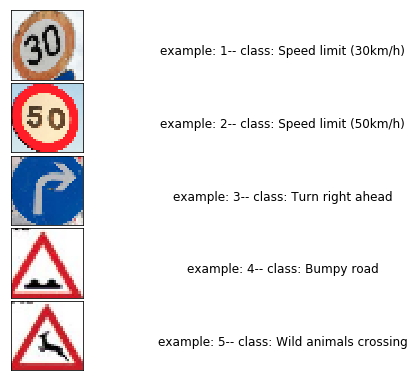

In [59]:
# Make sure the online test set looks correctly labeled
# and looks like reasonable input to the model
nsamples_col = 5
fig = plt.figure(figsize = (1,nsamples_col))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for i in range(nsamples_col):
    cls = y_online[i]
    clab = class_labels.values[cls,1]
    axis = fig.add_subplot(nsamples_col,1, i + 1, xticks=[], yticks=[])
    axis.imshow(X_online[i],aspect="auto")
    axis.yaxis.set_label_position("right")
    axis.set_ylabel('example: '+str(i+1)+'-- class: '+clab,rotation=0, fontsize=12, labelpad=200)
    
plt.show()

In [60]:
# applying preprocessing step to the online test images
X_online_pre,y_online_pre = augment_shuffle_norm(X_online, y_online,nsamples_class=None,
                                                 equalize=True,reshape_norm=True)

NO data generation
Normalizing and shuffling


### Predicting the Sign Type for Each Image

In [61]:
# getting the L-channels for each image
X_online_1ch = X_online_pre[:,:,:,1]
X_online_1ch = X_online_1ch.reshape(-1,32,32,1)

In [63]:
# computing predictions, and confidence levels from the model
with tf.Session() as sess:
    saver.restore(sess, './lenet_tf_chkpts')
    topk = sess.run(tf.nn.top_k(logits, k=5),feed_dict={x: X_online_1ch,fc_keep_prob: 1.0,cov_keep_prob: 1.0})
    predictions = sess.run(tf.argmax(logits, 1),feed_dict={x: X_online_1ch,fc_keep_prob: 1.0,cov_keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ./lenet_tf_chkpts


Below I show the preprocessed image, and the model output classification

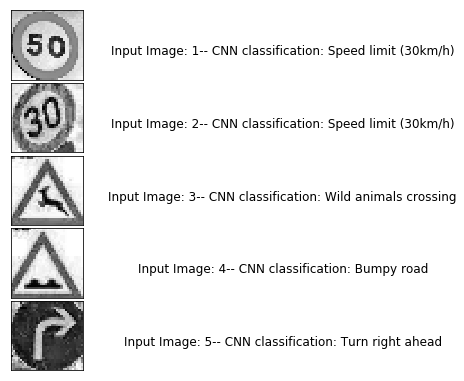

In [64]:
# Input images, and their classifications.
nsamples_rows = 5
fig = plt.figure(figsize = (1,nsamples_rows))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
#ridx = np.random.choice(range(len(X_valid_aug)),nsamples_row,replace=False)
ridx = [n for n in range(nsamples_rows)]
for i in range(nsamples_rows):
    cls = predictions[i]
    clab = class_labels.values[cls,1]
    axis = fig.add_subplot(nsamples_col,1, i + 1, xticks=[], yticks=[])
    axis.imshow(X_online_pre[i][:,:,1],aspect="auto",cmap='gray')
    axis.yaxis.set_label_position("right")
    axis.set_ylabel('Input Image: '+str(i+1)+'-- CNN classification: '+clab,rotation=0, fontsize=12, labelpad=200)
    
plt.show()

The model correctly classified each of the internet images, but how confident was the network in these classifications?

### Model Classification Confidence

We can get an idea of network classification confidence by looking at the logit values for the top 5 most likely classes (largest logit values) in each image case. Comparing logit values we can get an idea of confidence in the predictions. If there are large differences between the top 5 logit values than the class which was selected by the model is highly confident, while if the logits are similar than there is only minor information that influences the final classification and we should be less confident. Let's take a look at each image classification in terms of a bar chart of logit values for the classes as is done below.

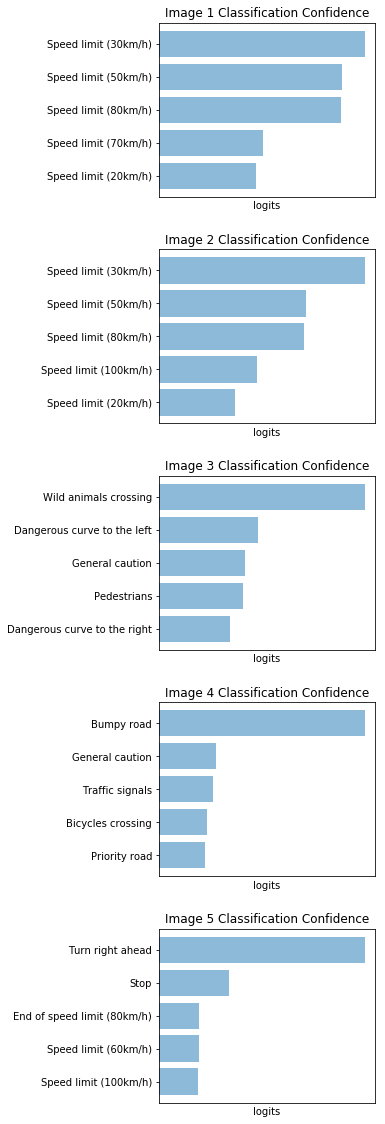

In [65]:
nsamples_rows = 5
fig = plt.figure(figsize = (3,3*nsamples_rows))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.3, wspace = 0.05)
for i in range(nsamples_rows):
    labels = [class_labels.values[j,1] for j in topk.indices[i]]
    axis = fig.add_subplot(nsamples_col,1, i + 1, xticks=[], yticks=[])
    axis.barh(range(5),topk.values[i],align='center', alpha=0.5);
    axis.set_yticks(range(5))
    axis.set_yticklabels(labels)
    axis.invert_yaxis()  # labels read top-to-bottom
    axis.set_xlabel('logits')
    axis.set_title('Image '+str(i+1)+' Classification Confidence')
    
plt.show()

For "Wild Animals Crossing," "Bumpy Road," and "Turn Right Ahead," the model is very confident in its selection, while for the speed limit signs it's easy to understand why its nearest classification cases are other speed limits.  Especially when at certain angles a 5 in the 50 km/hr speed limit could easily look like a 3 or an 8 even by a human!


## Class Precision and Recall

Well it's nice to know that our model seems to act in a way similar to human intelligence, but an additional method of determining how much we can trust our predictions is by looking at precision and recall for each class in our validation set. By looking at precision per class we are asking when our classifier predicts an image contains a particular class X, how often is that the class is truely in the image, or in other words when our model says X how sure are we it is X.  

On the other hand you could have a model that when it classifies an image as class X it is very sure of that, but it may not classify most of the true X's unless its really sure.  To measure how good a model is at picking up the majority of X's we compute recall, which is a measure of what fraction of the true X's are found out of the whole set.  I compute the recall and precision for each class per sign class below.

In [12]:
# computing predictions, and confidence levels from the model
with tf.Session() as sess:
    saver.restore(sess, './lenet_tf_chkpts')
    valid_pred = sess.run(tf.argmax(logits, 1),feed_dict={x:X_valid_aug_1ch,fc_keep_prob:1.0,cov_keep_prob:1.0})

INFO:tensorflow:Restoring parameters from ./lenet_tf_chkpts


In [30]:
# computing class precision and recall on the validation set
precision = []
recall = []
for cls in range(n_classes):
    tp = np.sum(y_valid_aug[(valid_pred==cls)]==cls)#true positives
    fp = np.sum(y_valid_aug[valid_pred==cls]!=cls)#false positives
    fn = np.sum(y_valid_aug[valid_pred!=cls]==cls)#false negatives
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))

In [34]:
pr_by_cls = pd.DataFrame({'precision':precision,'recall':recall})

In [35]:
pr_by_cls['class'] = class_labels.values[:,1]

In [37]:
pr_by_cls.set_index('class')

,precision,recall
class,,
Speed limit (20km/h),1.000000,1.000000
Speed limit (30km/h),0.995833,0.995833
Speed limit (50km/h),0.991736,1.000000
Speed limit (60km/h),1.000000,1.000000
Speed limit (70km/h),0.985915,1.000000
Speed limit (80km/h),1.000000,0.995238
End of speed limit (80km/h),1.000000,1.000000
Speed limit (100km/h),0.993377,1.000000
Speed limit (120km/h),1.000000,0.973333


The model has very high precision and recall across most of the classes, where only "slippery road," and "Danergous curve to the right" struggle to find all the cases but we should still be fairly confident in any images which are classifed as such, truely does include those signs (high percision).

## Inside the Neural Network -- Feature Maps

Ideally we would want to be able to understand the parameters of the model in a way that allows us to understand how the model would operate in the real world given any case.  However because the CNN is quite large, and has many non-linearities its difficult to understand what are the important features of an image that allows the model to correctly identify particular types of signs.  To that end we try and generate feature maps of standardized input images. 

Feature maps display the particular regions of the input image that activates convolutional layer filters.  When we see similar features activating a filter, such has edges at a 45 degree angle or large white spaces we can get an idea of what is the operation of a particular filter on determining what are the features the model considers important, and at least get a general idea of how the network might act given any image.  Let's look a standardized input image below and its 1st layer feature map images.

In [ ]:
# Loading in a standard test input image
test_img = np.array([X_valid[y_valid==13][80]])
test_img_fmap,y_fmap = augment_shuffle_norm(test_img,[[0]],nsamples_class=None,equalize=True,reshape_norm=True)

In [14]:
# putting it in the 1 channel mode
test_img_fmap_1ch = test_img_fmap[:,:,:,1]
test_img_fmap_1ch = test_img_fmap_1ch.reshape(-1,32,32,1)

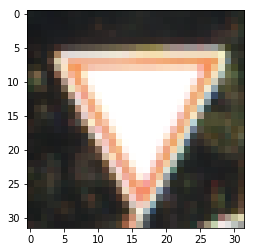

In [18]:
# show the input test image
plt.imshow(test_img[0]);

In [153]:
# function that outputs the activations per filter in particular layer given the input_image
def featureMaps(input_image, activation_layer,activation_min=-1,activation_max=1,plt_num=1):
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the 
    # variable from inside a function
    with tf.Session() as sess:
        saver.restore(sess, "./lenet_tf_chkpts")
        activation = activation_layer.eval(session=sess,feed_dict={x:input_image,cov_keep_prob:1.0,fc_keep_prob:1.0})
        featuremaps = activation.shape[3]
        
        combined_activation = np.zeros_like(activation[0,:,:,0])
        width = int(np.ceil(featuremaps/8))
        
        fig = plt.figure(figsize=(width*3,width*3/2))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.1)
        for featuremap in range(featuremaps):
            axis = fig.add_subplot(width,8,featuremap + 1, xticks=[], yticks=[])
            img = activation[0,:,:, featuremap]
            minI,maxI = np.min(img),np.max(img)            
            a = (1.-0)/(maxI-minI+1.e-6);
            b = -a*minI
            
            scaled_img = img*a+b
            axis.imshow(scaled_img, interpolation="nearest", cmap="gray",aspect='auto')
            combined_activation += scaled_img
    
    return combined_activation

INFO:tensorflow:Restoring parameters from ./lenet_tf_chkpts


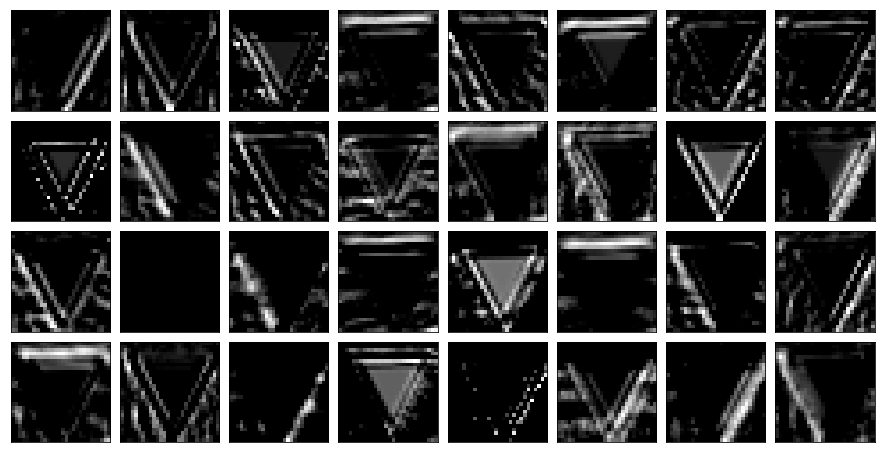

In [154]:
# the first layer 32 fitler activation feature map
combined = featureMaps(test_img_fmap_1ch,conv_0)

The first filter (upper left corner) seems to try to detect up and to the right edges while the 2nd filter seems to look for "V" shaped items. Further input images with those features could provide more evidence of that interpretation.  There also appears to be various scales of horizontal lines and large patches of a single color that activate several feature map images.  When I combine all the filter activations into a single image we see the example below.

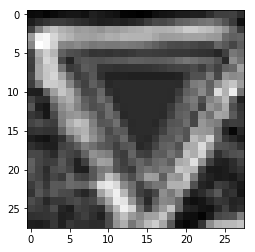

In [159]:
plt.imshow(combined,cmap='gray');

It seems the strongest activation highlights the original yield sign and ignores the background content, which is what we might expect for a system that can ID yield signs with no regard for the background.  You can view the feature map as a 32 channel image.  Though your eyes can't understand that abstraction the CNN attempts to do so.  If we use the same feature map code to view the next layer with the 32 channel image, it quickly becomes difficult to understand what features are activating the layer 2 filters as seen below.

INFO:tensorflow:Restoring parameters from ./lenet_tf_chkpts


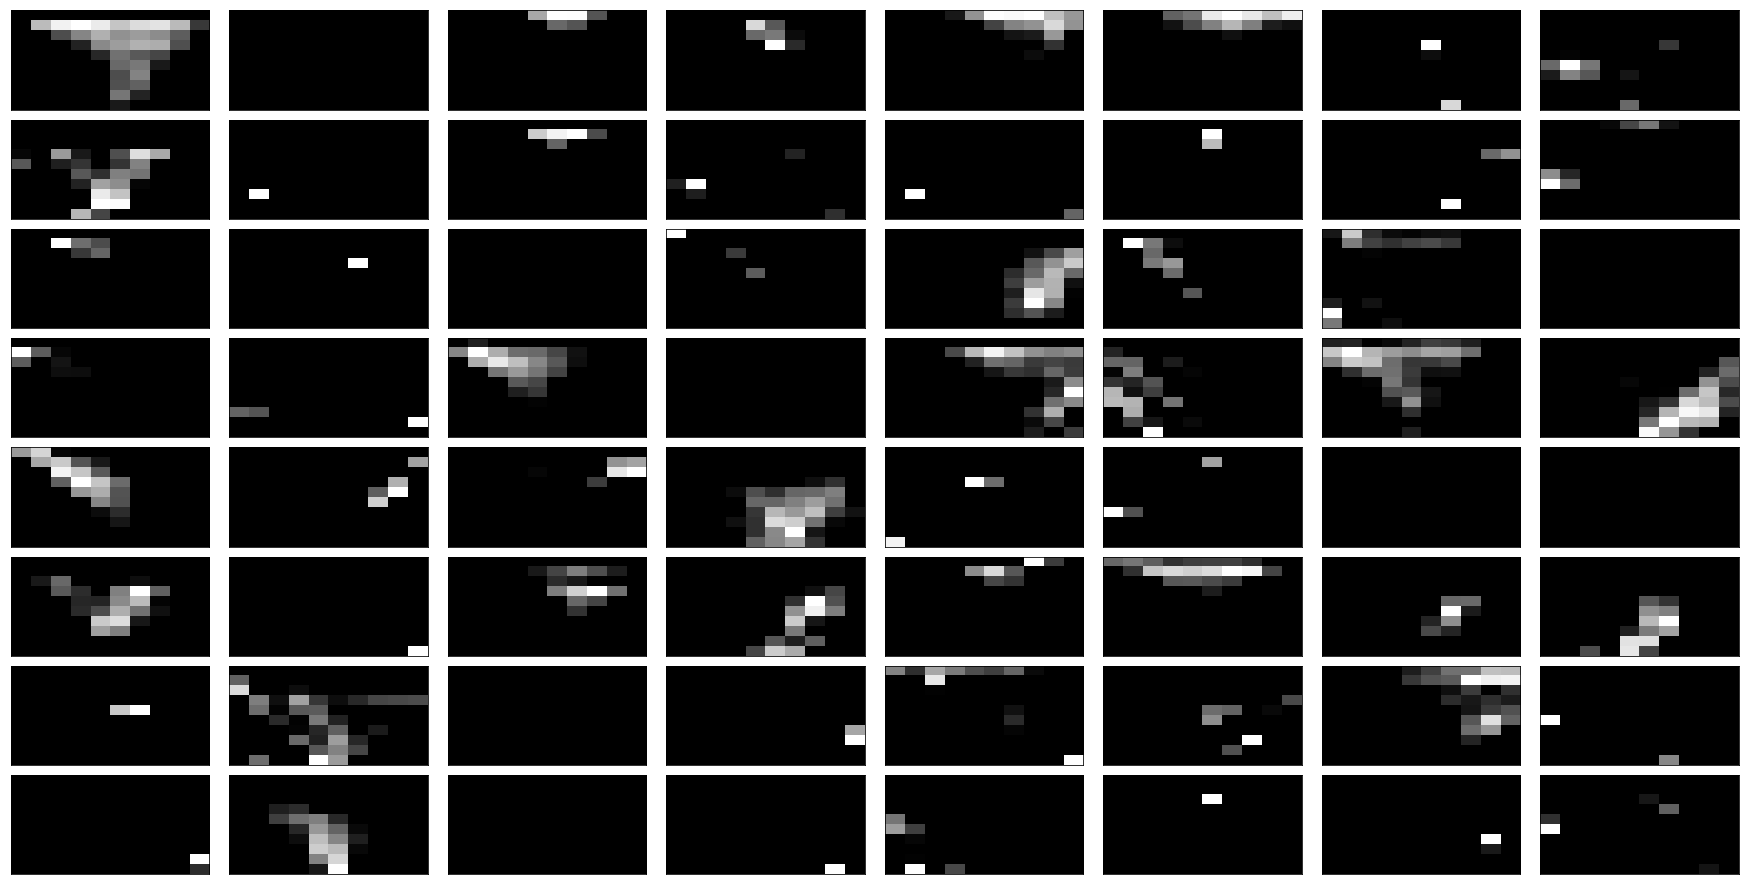

In [160]:
combined2 = featureMaps(test_img_fmap_1ch,conv_1)

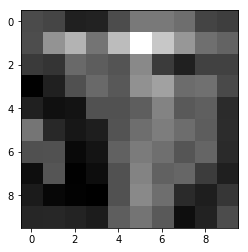

In [162]:
plt.imshow(combined2,cmap='gray');

At this point the activations are too abstract from the original image to be interpretable by me.


## Test Accuracy

As a final task we need to run the model on the test data once to get an idea of the general accuracy we can expect when used in the wild.

In [165]:
X_test_aug,y_test_1ch = augment_shuffle_norm(X_test, y_test, nsamples_class=None,equalize=True,reshape_norm=True)

NO data generation
Normalizing and shuffling


In [166]:
X_test_1ch = X_test_aug[:,:,:,1]
X_test_1ch = X_test_1ch.reshape(-1,32,32,1)

In [168]:
# computing test set accuracy
with tf.Session() as sess:
    BATCH_SIZE = 512
    saver.restore(sess, './lenet_tf_chkpts')
    test_accuracy,test_std = mean_accuracy(X_test_1ch, y_test_1ch)

print("test set accuracy: ", test_accuracy)

INFO:tensorflow:Restoring parameters from ./lenet_tf_chkpts
test set accuracy:  0.959218750493601


## Area for Improvements

Ultimately 95.9% accuracy on testing set isn't good enough for deployability. While it is high we are looking to target more in the 99% accuracy area across all data sets. In order to achieve this level of accuracy we're going to have to look at ways to improve this network and dataset. One of the obvious ways to potentially increase accuracy is to significantly expand our dataset. To do that in an efficient way we will want to take advantage of generators with the python framework. Essentially we don't want to store the dataset in memory as we did in the project above but generate the batches on the fly at run time. This can dramatically reduce the memory footprint to train the network, and effectively allows you to generate an infinite amount of data.

In terms of changes to the network it has been suggested to use Inception layers, along with batch normalization. The idea is to replace the tf.nn.max_pool components of the network where the kernel size is fixed to including multiple pooling layers with differing kernel sizes. Then let the network decide which pooling size is best for network performance! A link to a description of the Inception architecture can be found here. I plan to look at the accuracy this network can provide in future work